In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2025-06-30 07:57:14.494567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751270234.817846      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751270234.911087      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the model
model = load_model('/kaggle/input/model_/tensorflow2/default/1/resnet50.h5')

2025-06-30 07:57:36.116092: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
VAL_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
IMAGE_SIZE=(224,224)
BATCH_SIZE=16

# Normalize images
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

#Get class names
class_names = val_ds.class_names
val_ds=val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 17572 files belonging to 38 classes.


In [4]:
import glob

# List all image file paths
image_paths = glob.glob("/kaggle/input/new-plant-diseases-dataset/test/test/*.JPG")
image_paths.sort() 

#Define image loading and preprocessing function
def load_and_preprocess_image(path):
    path = tf.cast(path, tf.string)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image
    
#Create tf.data.Dataset
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
test_ds = path_ds.map(load_and_preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)


In [5]:
# Test Image paths
image_actual_classes=['AppleCedarRust','AppleCedarRust','AppleCedarRust','AppleCedarRust','AppleScab','AppleScab','AppleScab',
             'CornCommonRust','CornCommonRust','CornCommonRust','PotatoEarlyBlight','PotatoEarlyBlight','PotatoEarlyBlight',
             'PotatoEarlyBlight','PotatoEarlyBlight','PotatoHealthy','PotatoHealthy','TomatoEarlyBlight','TomatoEarlyBlight',
             'TomatoEarlyBlight','TomatoEarlyBlight','TomatoEarlyBlight','TomatoEarlyBlight','TomatoHealthy','TomatoHealthy',
             'TomatoHealthy','TomatoHealthy','TomatoYellowCurlVirus','TomatoYellowCurlVirus','TomatoYellowCurlVirus','TomatoYellowCurlVirus',
             'TomatoYellowCurlVirus','TomatoYellowCurlVirus']

In [6]:
# Grad-CAM heatmap function
def gradCAM_heatmap(img, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, prediction = grad_model(img)
        pred_idx = tf.argmax(prediction[0])
        class_channel = prediction[:, pred_idx]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + tf.keras.backend.epsilon()

    return heatmap.numpy()


In [7]:
def draw_gradcam_fill_and_outline(heatmap, original_img, threshold_ratio=0.5, 
                                   fill_color=(255, 150, 150), outline_color=(0,255, 0),
                                   fill_alpha=0.4, outline_thickness=1):
    # Convert float image to uint8 if needed
    if original_img.max() <= 1.0:
        img_uint8 = (original_img * 255).astype(np.uint8)
    else:
        img_uint8 = original_img.copy()

    # Resize and threshold heatmap
    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    threshold = int(threshold_ratio * 255)
    _, binary_mask = cv2.threshold(heatmap_resized, threshold, 255, cv2.THRESH_BINARY)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    # Create fill overlay
    overlay = np.full_like(img_uint8, fill_color, dtype=np.uint8)
    mask_3ch = np.stack([cleaned_mask]*3, axis=-1) // 255
    filled_img = np.where(mask_3ch, cv2.addWeighted(img_uint8, 1 - fill_alpha, overlay, fill_alpha, 0), img_uint8)

    # Draw contours (outline)
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = cv2.drawContours(filled_img.copy(), contours, -1, outline_color, outline_thickness)

    # Return in original scale
    return (outlined / 255.0) if original_img.max() <= 1.0 else outlined


In [8]:
y_pred=model.predict(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step


In [9]:
y_pred_idx=y_pred.argmax(axis=1)
y_pred_idx

array([ 2,  2,  2,  2,  0,  0,  0,  8,  8,  8, 20, 20, 20, 20, 20, 22, 22,
       29, 29, 29, 29, 29, 29, 37, 37, 37, 37, 35, 35, 35, 35, 35, 35])

In [10]:
y_pred=[class_names[i] for i in y_pred_idx]

In [11]:
y_pred

['Apple___Cedar_apple_rust',
 'Apple___Cedar_apple_rust',
 'Apple___Cedar_apple_rust',
 'Apple___Cedar_apple_rust',
 'Apple___Apple_scab',
 'Apple___Apple_scab',
 'Apple___Apple_scab',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Common_rust_',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___healthy',
 'Tomato___Early_blight',
 'Tomato___Early_blight',
 'Tomato___Early_blight',
 'Tomato___Early_blight',
 'Tomato___Early_blight',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___healthy',
 'Tomato___healthy',
 'Tomato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [12]:
image_actual_classes

['AppleCedarRust',
 'AppleCedarRust',
 'AppleCedarRust',
 'AppleCedarRust',
 'AppleScab',
 'AppleScab',
 'AppleScab',
 'CornCommonRust',
 'CornCommonRust',
 'CornCommonRust',
 'PotatoEarlyBlight',
 'PotatoEarlyBlight',
 'PotatoEarlyBlight',
 'PotatoEarlyBlight',
 'PotatoEarlyBlight',
 'PotatoHealthy',
 'PotatoHealthy',
 'TomatoEarlyBlight',
 'TomatoEarlyBlight',
 'TomatoEarlyBlight',
 'TomatoEarlyBlight',
 'TomatoEarlyBlight',
 'TomatoEarlyBlight',
 'TomatoHealthy',
 'TomatoHealthy',
 'TomatoHealthy',
 'TomatoHealthy',
 'TomatoYellowCurlVirus',
 'TomatoYellowCurlVirus',
 'TomatoYellowCurlVirus',
 'TomatoYellowCurlVirus',
 'TomatoYellowCurlVirus',
 'TomatoYellowCurlVirus']

In [13]:
all_imgs = list(test_ds.unbatch().as_numpy_iterator())

In [14]:
def get_adaptive_threshold(heatmap, percentile=85):
    flat = heatmap.flatten()
    return np.percentile(flat, percentile) / 255.0  # Normalize to [0, 1]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


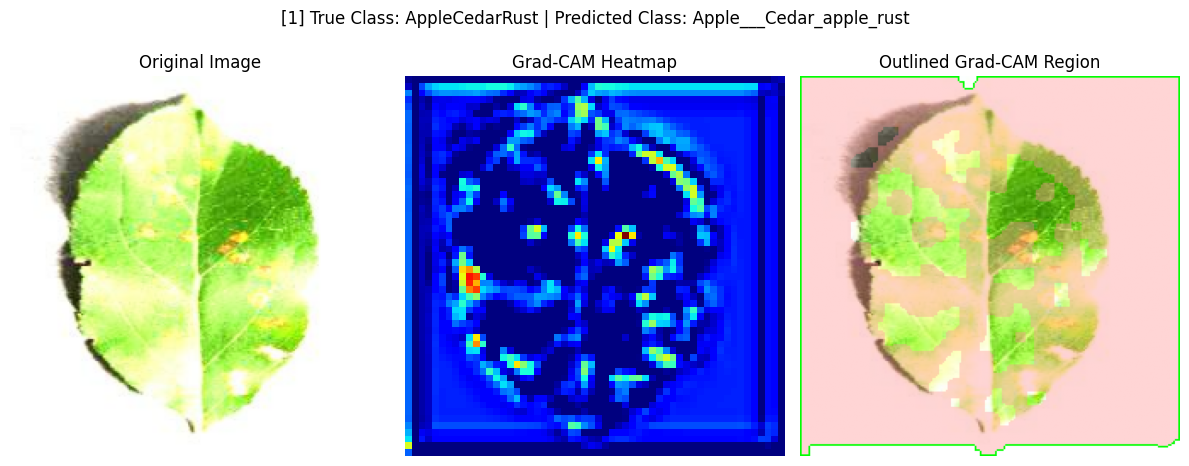

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


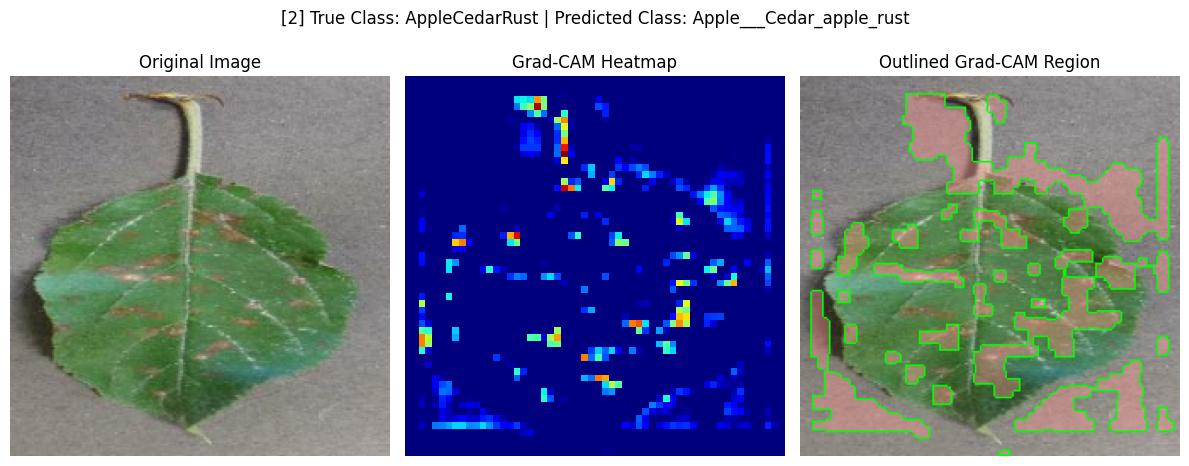

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


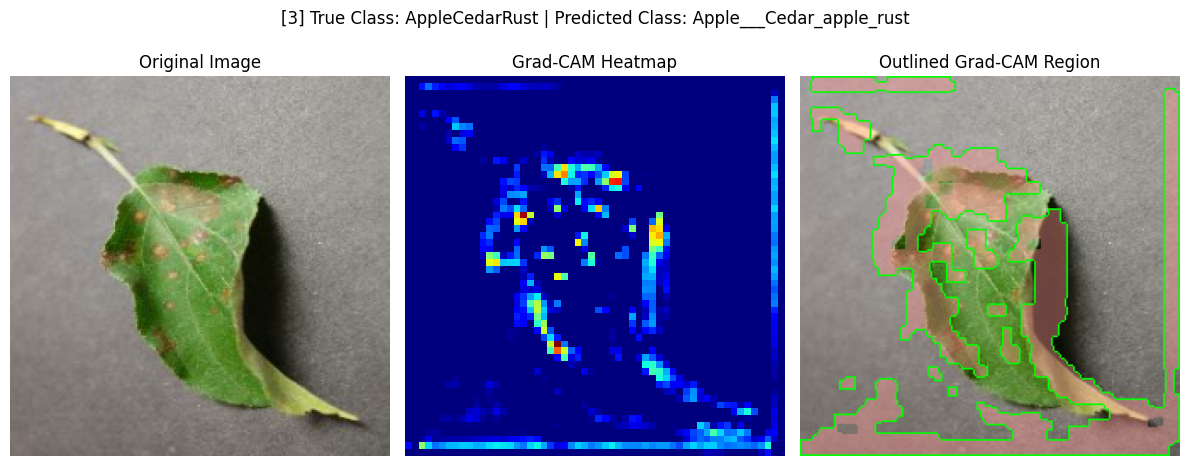

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


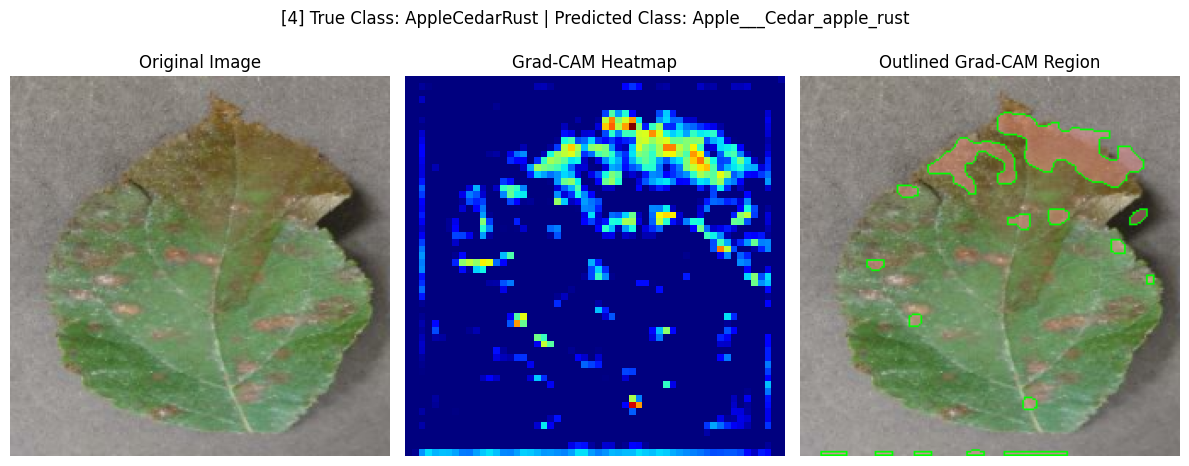

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [15]:
for i, y_pred_index in enumerate(y_pred_idx):
    img = all_imgs[i]

    heatmap = gradCAM_heatmap(img.reshape(1, 224, 224, 3), model, last_conv_layer_name="conv2d_16")

    # Automatically calculate threshold from heatmap
    if y_pred_index in [0,20,22,8,12,13,15,25,26]:
        percentile = 10
    elif y_pred_index in [3,4,6,10,14,17,19,23,24,27,37]:
        percentile = 99
    else:
        percentile = 85

    threshold = get_adaptive_threshold(heatmap, percentile=percentile)

    outlined_img = draw_gradcam_fill_and_outline(heatmap, img.reshape(224, 224, 3), threshold_ratio=threshold)

    # Plotting (same as before)
    predicted_class=y_pred[i]
    true_class = image_actual_classes[i]

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"[{i+1}] True Class: {true_class} | Predicted Class: {predicted_class}")

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img.reshape(224, 224, 3))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Outlined Grad-CAM Region")
    plt.imshow(outlined_img)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"gradcam_output_{i+1}.jpg")

    if i <= 3:
        plt.show()
    else:
        plt.close()